# Gibbs Sampling and linear regression.
Implemented according to the example in the book "Bayesian Statistics for Beginners, A step-by-step approach" by Donovan & Mickey

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pprint
%matplotlib inline

In [446]:
plt.rcParams['xtick.color'] = "white"
plt.rcParams['ytick.color'] = "white"
plt.rcParams['text.color'] = "black"
plt.rcParams['axes.labelcolor'] = "white"

In [429]:
d = open("survivor_data.txt","r").readlines()

In [430]:
data = pd.DataFrame()
for feature in d:
    f = feature.split(" ")
    data[f[0].strip(": ")] = list(map(lambda x: float(x),f[1:-1]))
data

,success,iq,years_in_school,grit
0,33.48,112.0,12.0,2.2
1,42.53,94.0,14.0,3.2
2,48.53,118.0,18.0,3.4
3,30.21,87.0,10.0,1.8
4,38.76,96.0,13.0,2.8
5,38.59,106.0,22.0,0.2
6,52.93,71.0,17.0,4.4
7,32.65,91.0,15.0,1.0
8,52.42,95.0,16.0,4.6
9,22.22,94.0,9.0,0.4


# Modelling relation between years_in_school and success

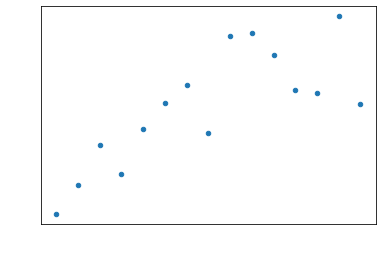

In [78]:
data.plot.scatter(x="years_in_school", y="success");

In [79]:
#data = (data-data.mean())/data.std()

## Assumptions

X = years_in_school

Y = success

## Model
$X$ ~ $\mathcal{N}(\mu, \tau)$
--
$Y_i$ ~ $\mathcal{N}(b_0 + b_1x_i, \tau)$
--
## Parameters

$b_0$ ~ $\mathcal{N}(\mu_0, \tau_0)$ --> Model intercept
--
$b_1$ ~ $\mathcal{N}(\mu_1, \tau_1)$ --> Model slope 
--
$\tau$ ~ $gamma(\alpha_0,\beta_0)$ --> Model precision = $\frac{1}{\sigma^{2}}$
--
### The precision must be positive, so we choose a gamma distribution.


## Hyper parameters
We will use vague priors (non-informative) for the model parameters $b_0, b_1$ 

### Intercept Prior
$\mu_0 = 0$
----------
$\tau_0 = 0.0001$ --> $\sigma^{2}=10000$
---------
### Slope Prior
$\mu_1 = 0$
---------
$\tau_1 = 0.0001$ --> $\sigma^{2}=10000$
---------

### The prior for $\tau$ is heavily shifted towards low numbers which means $high$ variance.
$\alpha_0 = 0.01$
----------
$\beta_0 = 0.01$
---------

# create object to trace all sampling steps

In [713]:
def get_trace(TRAILS, SAMPLES):
    trace = {
        "trail": list(i for i in range(TRAILS)),
        "samples":list(SAMPLES for _ in range(TRAILS)),
        
        "mu0": list(None for i in range(TRAILS)),
        "tau0": list(None for i in range(TRAILS)), 
        "proposal_b0": list(None for i in range(TRAILS)), 
        
        "mu1": list(None for i in range(TRAILS)), 
        "tau1": list(None for i in range(TRAILS)),
        "proposal_b1": list(None for i in range(TRAILS)),

        "SSE": list(None for i in range(TRAILS)), # Sum squared error
        "predicted_linear": list(np.zeros((SAMPLES,)) for i in range(TRAILS)), # a matrix of predicted values for each y_i will be generated at each trail
        "predicted_posterior": list(np.zeros((SAMPLES,)) for i in range(TRAILS)),
        
        "alpha": list(None for i in range(TRAILS)),
        "beta": list(None for i in range(TRAILS)),
        "proposal_tau": list(None for i in range(TRAILS)),
        
        "likelihood": list(None for i in range(TRAILS)), # likelihood of model given the data
        "log_likelihood" : list(None for i in range(TRAILS)),
        "neg_double_log_likelihood" : list(None for i in range(TRAILS)),
    }
    return trace
#trace = get_trace(TRAILS=10, SAMPLES=len(data))

# Set Prior distributions

In [714]:
def set_priors(trace):
    trace["mu0"][0] = 0
    trace["tau0"][0] = 0.0001
    trace["mu1"][0] = 0
    trace["tau1"][0] = 0.0001
    trace["alpha"][0] = 0.01
    trace["beta"][0] = 0.01
    return trace

#trace = set_priors(trace)

# Prime our MCMC sampler

In [715]:
def prime_MCMC(trace):
    trace["proposal_b0"][0] = 6
    trace["proposal_b1"][0] = 0.3
    # Tau needed not to be set here in the first step since we will sample this conditioned on b0 and b1
    trace["proposal_tau"][0] = None 
    return trace
#trace = prime_MCMC(trace)

In [716]:
import scipy.stats as stats
import numpy as np

In [727]:
def compute_SSE(trace, data, trail):
    for i, observation in data.iterrows():
        intercept = trace["proposal_b0"][trail]
        slope = trace["proposal_b1"][trail] 
        x = observation["years_in_school"]
        trace["predicted_linear"][trail][i] = intercept + (slope * x)
    diff = data["success"].values - np.array(trace["predicted_linear"][trail])
    trace["SSE"][trail] = sum([err**2 for err in diff]) #diff.dot(diff)
    return 

In [728]:
def update_tau_parameters(trace, trail):
    """Update the proposal distribution of tau, conditioned on the current values of b0 and b1"""
    
    # The prior of alpha and beta is always chosen as the first term in the conjugate solution update.
    # and we have always the same sample size
    n = trace["samples"][0]
    alpha_prior = trace["alpha"][0]
    trace["alpha"][trail] = alpha_prior + (n / 2)
    
    # We use the previous rounds Sum squared error to update beta. i.e the intercept and slope from the previous
    # round is used to update beta.
    beta_prior = trace["beta"][0]
    trace["beta"][trail] = beta_prior + (trace["SSE"][trail-1] / 2)
    return 

In [729]:
from scipy.stats import gamma

def update_tau_proposal(trace, trail):
    # numpy uses scale = 1/rate
    scale = 1/trace["beta"][trail]
    trace["proposal_tau"][trail] = np.random.gamma(shape=trace["alpha"][trail], scale=scale)
    return

In [730]:
def update_b0_parameters(trace, data, trail):
    
    tau0_prior = trace["tau0"][0]
    mu0_prior = trace["mu0"][0]
    n = trace["samples"][0]
    
    trace["mu0"][trail] = ((tau0_prior * mu0_prior) + \
                        trace["proposal_tau"][trail] * \
                        sum([
                            obs["success"] - (trace["proposal_b1"][trail-1] * obs["years_in_school"])
                        for _, obs in data.iterrows()])) / (tau0_prior + n * trace["proposal_tau"][trail])
    
    trace["tau0"][trail] = tau0_prior + (n * trace["proposal_tau"][trail])
    
    return

In [731]:
def update_b0_proposal(trace, trail):
    mu = trace["mu0"][trail]
    std = np.sqrt(1/trace["tau0"][trail])
    trace["proposal_b0"][trail] = np.random.normal(mu, std)
    return

In [732]:
def update_b1_parameters(trace, data, trail):
    
    tau1_prior = trace["tau1"][0]
    mu1_prior = trace["mu1"][0]
    n = trace["samples"][0]
    squared_data = sum([obs["years_in_school"]**2 for _, obs in data.iterrows()])
    
    trace["mu1"][trail] = ((tau1_prior * mu1_prior) + \
                        trace["proposal_tau"][trail] * \
                        sum([
                             obs["years_in_school"] * (obs["success"] - trace["proposal_b0"][trail])
                        for _, obs in data.iterrows()])) / (tau1_prior + (trace["proposal_tau"][trail] * squared_data))
    
    trace["tau1"][trail] = (tau1_prior + (trace["proposal_tau"][trail] * squared_data))
    
    return

In [733]:
def update_b1_proposal(trace, trail):
    mu = trace["mu1"][trail]
    std = np.sqrt(1/trace["tau1"][trail])
    trace["proposal_b1"][trail] = np.random.normal(mu, std)
    return

In [738]:
def predict_posterior(trace, trail):
    mu = trace["predicted_linear"][trail]
    std = 1/np.sqrt(trace["proposal_tau"][trail])
    trace["predicted_posterior"][trail] = np.random.normal(mu,std) 
    return

In [739]:
from numpy import prod

def _normal(tau, y, pred):
    return np.sqrt(tau)/np.sqrt(2*np.pi) * np.exp((-tau/2)*((y-pred)**2))

def compute_likelihoods(trace, data, trail):
    intercept = trace["proposal_b0"][trail]
    slope = trace["proposal_b1"][trail]
    tau = trace["proposal_tau"][trail]
    like = [ _normal(tau, obs["success"], intercept+slope*obs["years_in_school"]) for _, obs in data.iterrows() ]
    trace["likelihood"][trail] = prod(like)
    trace["log_likelihood"][trail] = sum(map(np.log,like))
    trace["neg_double_log_likelihood"][trail] = sum(map(lambda l: -2*np.log(l),like))

In [740]:
from tqdm.notebook import tqdm

def GIBBS_sampler(trace, TRAILS):
    
    # first we need the Sum squared error to update Tau in the first round
    compute_SSE(trace, data, 0)
    
    # Now comes the rest of the trails..
    for trail in tqdm(range(1, TRAILS)): 
        
        #update tau (error term)
        update_tau_parameters(trace, trail)
        update_tau_proposal(trace, trail)
        
        #update intercept
        update_b0_parameters(trace, data, trail)
        update_b0_proposal(trace, trail)
        
        #update slope
        update_b1_parameters(trace, data, trail)
        update_b1_proposal(trace, trail)
        
        # Compute sum squared error
        compute_SSE(trace, data, trail)
        
        # Compute model likelihoods
        compute_likelihoods(trace, data, trail)
        
        # Predict using posterior
        predict_posterior(trace, trail)
        
    return trace

TRAILS=500 # 2*10e3
burn_in = int(TRAILS * 0.25)
trace = get_trace(TRAILS,
                  SAMPLES=len(data))

trace = set_priors(trace)
trace = prime_MCMC(trace)
trace = GIBBS_sampler(trace, TRAILS)

In [741]:
#import collections
#trace_ordered = collections.OrderedDict(sorted(trace.items()))
#trace_ordered

# Plot Sum squared errors

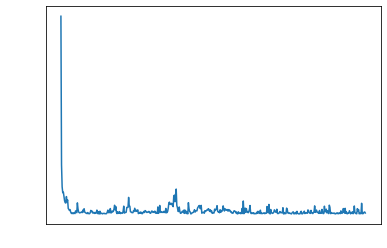

In [742]:
plt.plot(trace["SSE"])
plt.show()

# Plot model likelihood over trails

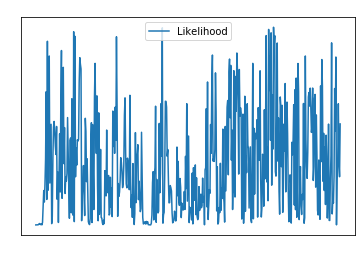

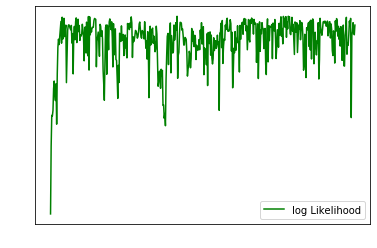

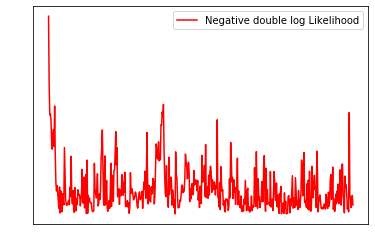

In [743]:
plt.plot(trace["likelihood"], label="Likelihood")
plt.legend()
plt.show()
plt.plot(trace["log_likelihood"], color="g", label = "log Likelihood")
plt.legend()
plt.show()
plt.plot(trace["neg_double_log_likelihood"], color="r", label = "Negative double log Likelihood")
plt.legend()
plt.show()

# Remove burn in period

In [744]:
trace = pd.DataFrame().from_dict(trace)

In [745]:
trace = trace.iloc[int(burn_in):, :] #{key:trace[key][int(burn_in):] for key in trace}

In [746]:
trace.head()

,trail,samples,mu0,tau0,proposal_b0,mu1,tau1,proposal_b1,SSE,predicted_linear,predicted_posterior,alpha,beta,proposal_tau,likelihood,log_likelihood,neg_double_log_likelihood
125,125,15,17.944691,0.268566,18.612890,1.354906,65.416353,1.478550,982.813074,"[36.35548898844897, 39.312588756610324, 45.226...","[46.60557982430588, 34.4460013571303, 38.66705...",7.51,509.603812,0.017898,1.230236e-23,-52.752251,105.504502
126,126,15,15.926664,0.360327,16.642939,1.476176,87.775526,1.684402,1040.983881,"[36.85576351355782, 40.2245676166753, 46.96217...","[33.93347670211439, 47.29541242451908, 47.1332...",7.51,491.416537,0.024015,2.746263e-24,-54.251801,108.503602
127,127,15,12.836749,0.195969,11.284076,1.806063,47.726774,1.763256,813.489554,"[32.44315167782478, 35.96966434929135, 43.0226...","[45.17496038590296, 29.234983758322965, 56.403...",7.51,520.501941,0.013058,3.767584e-23,-51.633023,103.266046
128,128,15,11.657209,0.355574,11.295669,1.805351,86.617318,1.688373,856.899789,"[31.556142300346547, 34.93288787919681, 41.686...","[29.545461010980915, 36.01780085368503, 43.210...",7.51,406.754777,0.023698,2.596612e-23,-52.005250,104.010500
129,129,15,12.779944,0.336634,13.861569,1.647395,82.002174,1.673852,837.531358,"[33.94779610867852, 37.29550061349333, 43.9909...","[34.593392281470315, 46.337335425009044, 41.63...",7.51,428.459895,0.022436,3.675994e-23,-51.657633,103.315267


# Summarize proposals

In [791]:
summary = trace[["proposal_b0", "proposal_b1", "proposal_tau"]].agg(["min","max","mean","median","std"]).T
summary

,min,max,mean,median,std
proposal_b0,-21.673259,28.210405,7.247631,6.762829,8.254015
proposal_b1,0.701672,3.789597,2.050854,2.082978,0.526318
proposal_tau,0.003543,0.040717,0.016668,0.015900,0.006796


In [800]:
alpha_posterior = trace["alpha"].iloc[-1]
beta_posterior = alpha_posterior / trace["proposal_tau"].mean()
print("Posterior alpha: {} \nPosterior beta: {}".format(alpha_posterior, beta_posterior))

Posterior alpha: 7.51 
Posterior beta: 450.57519643457425


# Plot posterior predictive distribution

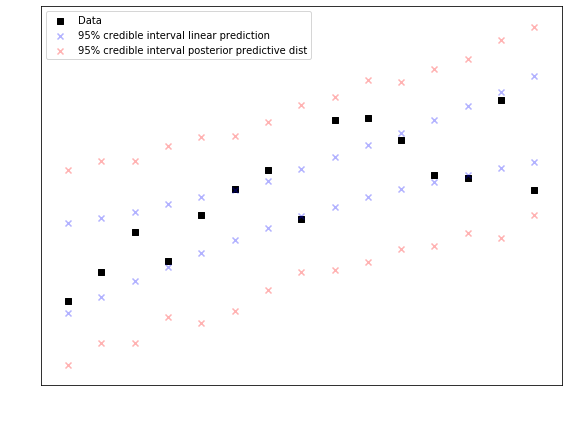

In [816]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

# plot data
data.plot.scatter(x="years_in_school", y="success", color="k", marker=",", label="Data", s=40)

#plot credible 95% interval of predictions
predictions_linear = np.array(list(x for x in trace["predicted_linear"].values))[:,:]
lower_credible_interval_linear = np.percentile(predictions_linear,2.5, axis=0)
upper_credible_interval_linear = np.percentile(predictions_linear,97.5, axis=0)
plt.scatter(data["years_in_school"], lower_credible_interval_linear, color="b", alpha=0.3, marker="x", label="95% credible interval linear prediction")
plt.scatter(data["years_in_school"], upper_credible_interval_linear, color="b", alpha=0.3, marker="x")

# plot posterior predictive distroibution
predictions_posterior = np.array(list(x for x in trace["predicted_posterior"].values))[:,:]
lower_credible_interval_posterior = np.percentile(predictions_posterior,2.5, axis=0)
upper_credible_interval_posterior = np.percentile(predictions_posterior,97.5, axis=0)
plt.scatter(data["years_in_school"], lower_credible_interval_posterior, color="r", alpha=0.3, marker="x", label="95% credible interval posterior predictive dist")
plt.scatter(data["years_in_school"], upper_credible_interval_posterior, color="r", alpha=0.3, marker="x")

plt.legend()
plt.tight_layout()
plt.show()

# Plot the parameters posterior distributions

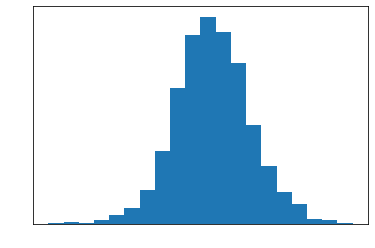

In [455]:
plt.hist(trace["proposal_b0"],bins=20)
plt.show()
#pprint.pprint(trace["proposal_b0"])
#print(min(trace["proposal_b0"]), max(trace["proposal_b0"]))

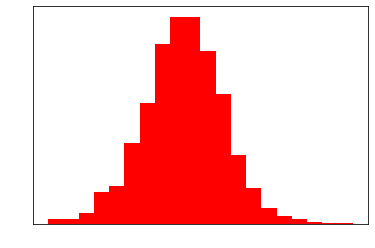

In [456]:
plt.hist(trace["proposal_b1"], color="r", bins=20)
plt.show()
#pprint.pprint(trace["proposal_b1"])
#print(min(trace["proposal_b1"]), max(trace["proposal_b1"]))

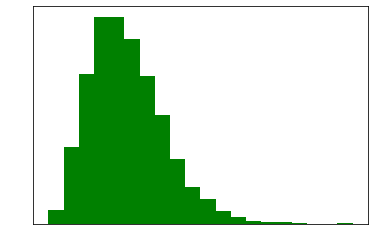

In [457]:
plt.hist(trace["proposal_tau"][1:], color="g", bins=20)
plt.show()
#pprint.pprint(trace["proposal_tau"])
#print(min(trace["proposal_tau"][1:]), max(trace["proposal_tau"][1:]))

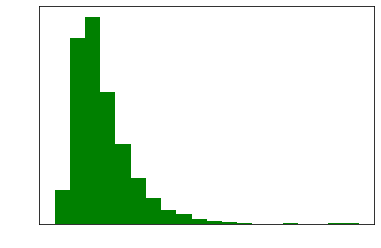

In [458]:
plt.hist([1/x for x in trace["proposal_tau"][1:]], color="g", bins=20)
plt.show()

# Diagnostic plots

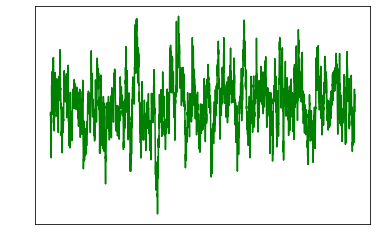

In [459]:
plt.plot(trace["mu0"], color="g")
plt.show()
#pprint.pprint(trace["mu0"])

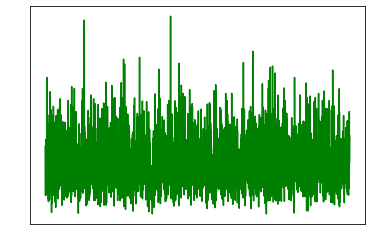

In [460]:
plt.plot(trace["tau0"], color="g")
plt.show()
#pprint.pprint(trace["tau0"])

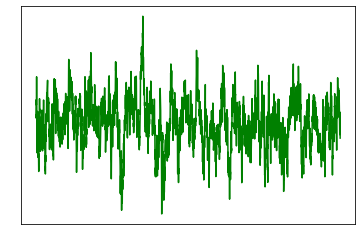

In [461]:
plt.plot(trace["mu1"], color="g")
plt.show()
#pprint.pprint(trace["mu1"])

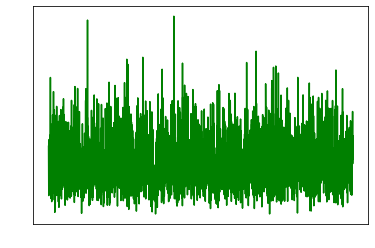

In [462]:
plt.plot(trace["tau1"], color="g")
plt.show()
#pprint.pprint(trace["tau1"])

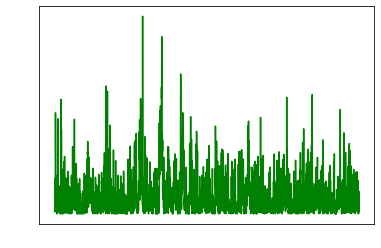

In [481]:
plt.plot(trace["beta"], color="g")
plt.show()